In [1]:
import torch
nn = torch.nn
import torch.nn.functional as F
import numpy as np

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import unicodedata
import string

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:


def findFiles(path): return glob.glob(path)


all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('Is dictionary category_lines successfully created:')
print(category_lines['Italian'][:5])

#######################################################

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

############ data processing ###########################

category_to_index = {}
for i in range(n_categories):
  lang = all_categories[i]
  category_to_index[lang] = i

name_list = []
index_list = []
for lang in category_lines:
  name_list = name_list + category_lines[lang]
  n = len(category_lines[lang])
  ind = category_to_index[lang]
  index_list = index_list + [ind]*n
  
assert len(name_list) == len(index_list)
n_data = len(name_list)

data_ind = np.arange(n_data)
np.random.shuffle(data_ind)
train_ind, valid_ind, test_ind = np.split(data_ind, [int(.8*n_data), int(.9*n_data)]) 
# you need to set seed here so that your train/test data are the same every time!!!
n_train = len(train_ind)
n_valid = len(valid_ind)

print('n_train:')
print(n_train)
print('check if train_ind looks right:')
print(train_ind[:30])

Is dictionary category_lines successfully created:
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
n_train:
16059
check if train_ind looks right:
[ 5069  4237 19693  5159   485   288  5938 13795   491  5684  6787  4941
  8060 16115  7061 14312 13514  3149  6712  3479 15032 10456   952 18727
  9096 16608  3587  1830  5356 17007]


In [ ]:
#device = torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
class My_RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_stack=2):
    super(My_RNN, self).__init__()
    self.hidden_size = hidden_size
    self.h0 = torch.zeros((n_stack, hidden_size), device=device)
    # https://stackoverflow.com/questions/54155969/pytorch-instance-tensor-not-moved-to-gpu-even-with-explicit-cuda-call
    self.c0 = torch.zeros((n_stack, hidden_size), device=device)
    self.block = nn.LSTM(input_size, hidden_size, num_layers=n_stack)
    self.decoder_input_size = (torch.flatten(torch.cat((self.h0, self.c0)))).size()[0]
    self.decoder = nn.Linear(self.decoder_input_size, output_size)

  def forward(self, inp, hidden):
    # hidden: (h, c)
    return self.block(inp, hidden) # out, (h, c)

  def get_output(self, final_hidden):
    out = torch.cat(final_hidden)
    out = torch.flatten(out)
    out = self.decoder(out)
    return out

  def getInitHidden(self):
    return (self.h0, self.c0)

HIDDEN_SIZE = 128
n_batch = 32
lr = 1e-2 # first, I used 5e-3
rnn = My_RNN(n_letters, HIDDEN_SIZE, n_categories).to(device)

In [ ]:
for name, p in rnn.named_parameters():
  print(f'{name}')

block.weight_ih_l0
block.weight_hh_l0
block.bias_ih_l0
block.bias_hh_l0
block.weight_ih_l1
block.weight_hh_l1
block.bias_ih_l1
block.bias_hh_l1
decoder.weight
decoder.bias


In [ ]:
def train(name, true_index):
  # modifies parameters of the model after the model sees *only one* data point.
  # name: tensor
  # e.g. name = lineToTensor('Jones'), whose shape is [5, 1, n_letters]
  # true_index: tensor of an integer

  hidden = rnn.getInitHidden()
  name_len = name.size()[0]
  for i in range(name_len):
    input_letter = name[i]
    _, hidden = rnn(input_letter, hidden)

  out = rnn.get_output(hidden)
  loss = F.cross_entropy(out, true_index)
  loss.backward()

  with torch.no_grad():
    for p in rnn.parameters():
      p -= p.grad * lr / n_batch
    
    rnn.zero_grad()

  return out, loss.item()


def evaluate(name):
  # name: tensor
  # e.g. name = lineToTensor('Jones'), whose shape is [5, 1, n_letters]

  hidden = rnn.getInitHidden()
  name_len = name.size()[0]  

  with torch.inference_mode():
    for i in range(name_len):
      input_letter = name[i]
      # input_letter must have shape [1, input_size of block]
      _, hidden = rnn(input_letter, hidden)

    out = rnn.get_output(hidden)

  return out


def get_val_loss():
  # randomly selects n_batch validation samples and calculate average loss
  loss_sum = 0
  arr = np.random.choice(n_valid, n_batch)
  for j in arr:
    ind = valid_ind[j]
    name_tensor = lineToTensor(name_list[ind]).to(device)
    true_index = torch.tensor(index_list[ind], device=device)

    loss = F.cross_entropy(evaluate(name_tensor), true_index)
    loss_sum += loss.item()

  return loss_sum / n_batch




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
epochs = 100
n_iters = epochs*n_train
print_every = 1000
loss_sum = 0
avg_loss_list = []
val_loss_list = []

for iter in range(1, n_iters+1):
  ind = train_ind[(iter-1) % n_train]
  name_tensor = lineToTensor(name_list[ind]).to(device)
  true_index = torch.tensor(index_list[ind], device=device)

  _, loss = train(name_tensor, true_index)
  loss_sum += loss

  if iter % print_every == 0:
    avg_loss = loss_sum / print_every
    val_loss = get_val_loss()
    # https://stackoverflow.com/questions/48152674/how-do-i-check-if-pytorch-is-using-the-gpu
    #mem = torch.cuda.memory_allocated(device)/1024**2 # MB
    print(f'iter: {iter} | loss: {avg_loss} | val_loss: {val_loss}')
    avg_loss_list.append(avg_loss)
    val_loss_list.append(val_loss)
    loss_sum = 0

  # shuffle training data every epoch
  # and save
  if iter % n_train == 0:
    np.random.shuffle(train_ind)

    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save({
      'rnn_state_dict': rnn.state_dict(),
      'avg_loss_list': avg_loss_list,
      'val_loss_list': val_loss_list,
      'iter': iter,
      'lr': lr
    }, f'/content/gdrive/My Drive/Colab/pytorch/char_rnn_0114_lr={lr}.pt')

iter: 1000 | loss: 2.8091768474578855 | val_loss: 2.7425247207283974
iter: 2000 | loss: 2.6201798267364502 | val_loss: 2.447447694838047
iter: 3000 | loss: 2.3707992873191834 | val_loss: 2.117884773761034
iter: 4000 | loss: 2.206922949552536 | val_loss: 2.1313495598733425
iter: 5000 | loss: 2.0286744327545168 | val_loss: 1.694436190649867
iter: 6000 | loss: 1.9473480289578438 | val_loss: 1.9061798471957445
iter: 7000 | loss: 1.915565018236637 | val_loss: 1.9534506369382143
iter: 8000 | loss: 1.9022106879353524 | val_loss: 2.114835415035486
iter: 9000 | loss: 1.816251035630703 | val_loss: 1.892125926911831
iter: 10000 | loss: 1.8581508147120476 | val_loss: 1.8974670823663473
iter: 11000 | loss: 1.8591978306174277 | val_loss: 1.4262237716466188
iter: 12000 | loss: 1.9008185185790063 | val_loss: 1.8145073466002941
iter: 13000 | loss: 1.815715695500374 | val_loss: 2.0222086664289236
iter: 14000 | loss: 1.799195326924324 | val_loss: 1.8274018503725529
iter: 15000 | loss: 1.8346175855994225 

In [ ]:
ckpt = torch.load('/content/gdrive/My Drive/Colab/pytorch/char_rnn_0114.pt', map_location=device)
avg_loss_list = ckpt['avg_loss_list']
val_loss_list = ckpt['val_loss_list']

ckpt01 = torch.load('/content/gdrive/My Drive/Colab/pytorch/char_rnn_0114_lr=0.01.pt', map_location=device)
avg_loss_list01 = ckpt01['avg_loss_list']
val_loss_list01 = ckpt01['val_loss_list']

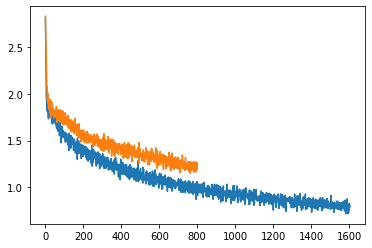

In [ ]:
fig, ax = plt.subplots()
ax.plot(avg_loss_list01) 
# the longer one is avg_loss_list01, which uses lr=.01
# it performs better
ax.plot(avg_loss_list)

In [ ]:
rnn.load_state_dict(ckpt01['rnn_state_dict'])

<All keys matched successfully>

In [ ]:
print(name_list[test_ind[23]])
print(all_categories[index_list[test_ind[23]]])

Zipperer
Czech


In [ ]:
all_categories

['Japanese',
 'Czech',
 'English',
 'Greek',
 'Scottish',
 'Arabic',
 'Vietnamese',
 'Spanish',
 'Chinese',
 'German',
 'Korean',
 'Polish',
 'French',
 'Irish',
 'Russian',
 'Italian',
 'Dutch',
 'Portuguese']

In [ ]:
evaluate(lineToTensor('Romano')) # yes, italian

tensor([ 3.3230,  1.0041,  0.0769, -0.6725, -0.0733, -3.0294, -2.9685,  3.0186,
        -5.1058, -1.3248, -3.0795,  0.7524,  0.3908,  0.4152,  1.5720,  5.1921,
        -0.8328,  1.7394])

In [ ]:
# try Romano vs. Romanov
# see if long-term memory changes...